## MLP on DE with ODE Losses

In [1]:
# Importing packages
using Lux
using Zygote
using Optimization
using OptimizationOptimisers
using Random
using Statistics
using DifferentialEquations
using Plots
using ComponentArrays
using NNlib

In [2]:
struct SIR_params
    β::Float32
    γ::Float32
end

# SIR model method for DifferentialEquations call 
function SIR_model!(du, u, p::SIR_params, t)
    S, I, R = u
    du[1] = -p.β * S * I 
    du[2] =  p.β * S * I - p.γ * I
    du[3] =  p.γ * I
end

# SIR model non mutating function method to calculate NN RHS
SIR_model(y::AbstractMatrix{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1, :] .* y[2, :]        
    dI = p.β .* y[1,:] .* y[2, :] - p.γ .* y[2, :]
    dR = p.γ .* y[2, :]                         
    permutedims(hcat(dS, dI, dR))
end

SIR_model(y::AbstractVector{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1] .* y[2]        
    dI = p.β .* y[1] .* y[2] - p.γ .* y[2]
    dR = p.γ .* y[2]                         
    permutedims(hcat(dS, dI, dR))
end


# Fast default RNG. Does not get messed up with a global RNG
rng = Random.MersenneTwister(42)

true_SIR_par = SIR_params(0.30, 0.1)
t_span = (0.0, 60.0)
N_obs = 101

# Collect seems to turn an iterable into an array
t_obs_array = range(t_span[1], t_span[2], length=N_obs) |> collect
u0 = [0.999, 0.001, 0.0]

prob = DifferentialEquations.ODEProblem(SIR_model!, u0, t_span, true_SIR_par)
sol = DifferentialEquations.solve(
    prob,
    DifferentialEquations.Tsit5();
    saveat = t_obs_array
)
sol_ = Array(sol)

# --- multiplicative % noise via lognormal, unbiased & positive ---
noise_pct = 0.2
ε = Random.randn(rng, size(sol_)...)
noisy_data = sol_ .* exp.(noise_pct .* ε .- 0.5 * noise_pct^2) 
noisy_data = clamp.(noisy_data, 0, Inf32)

# Convert to Float32 to keep everyone happy
t_train = Float32.(t_obs_array)
Y_train = Float32.(noisy_data)
y0_obs  = Y_train[:, 1]     # IC for penalty

Y_train_std = Statistics.std(Y_train, dims=2)


3×1 Matrix{Float32}:
 0.39722162
 0.11136482
 0.29236832

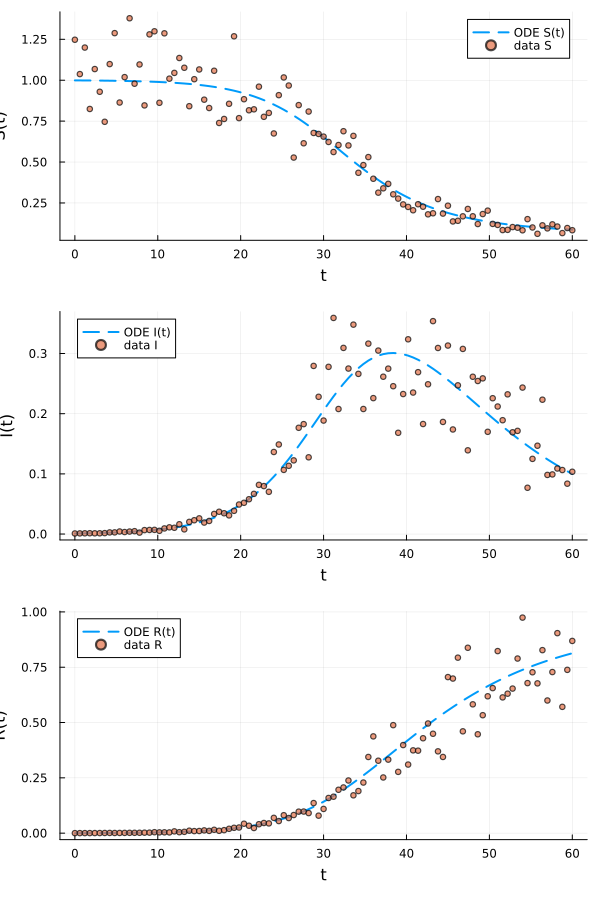

In [3]:

# A smooth time grid for plotting the NN curve
t_plot = Float32.(collect(range(t_span[1], t_span[2], length=400)))


# Split true, NN, and noisy series
S_true, I_true, R_true = sol_[1, :], sol_[2, :], sol_[3, :]
S_noisy, I_noisy, R_noisy = Y_train[1, :], Y_train[2, :], Y_train[3, :]

# Panel 1: S(t)
p1 = Plots.plot(t_obs_array, S_true; label = "ODE S(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p1, t_train, S_noisy; label = "data S", ms = 3, alpha = 0.7)
Plots.xlabel!(p1, "t")
Plots.ylabel!(p1, "S(t)")

# Panel 2: I(t)
p2 = Plots.plot(t_obs_array, I_true; label = "ODE I(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p2, t_train, I_noisy; label = "data I", ms = 3, alpha = 0.7)
Plots.xlabel!(p2, "t")
Plots.ylabel!(p2, "I(t)")

# Panel 3: R(t)
p3 = Plots.plot(t_obs_array, R_true; label = "ODE R(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p3, t_train, R_noisy; label = "data R", ms = 3, alpha = 0.7)
Plots.xlabel!(p3, "t")
Plots.ylabel!(p3, "R(t)")

# Combine panels
plt = Plots.plot(p1, p2, p3; layout = (3, 1), size = (600, 900))
display(plt)

In [4]:
NN_model = Lux.Chain(
    Lux.Dense(1, 10, tanh),
    Lux.Dense(10, 10, tanh),
    Lux.Dense(10, 3, NNlib.softplus) # forces outputs to be positive
)

ps, st = Lux.setup(rng, NN_model)
ps = ComponentArrays.ComponentArray(ps)


ComponentVector{Float32}(layer_1 = (weight = Float32[0.101003505; -1.5794787; … ; -1.5328639; -1.1865367;;], bias = Float32[0.78094625, 0.9930184, 0.263072, -0.34331846, 0.49155998, 0.54797864, -0.4149456, -0.40966392, -0.19459105, 0.4064026]), layer_2 = (weight = Float32[-0.26765984 0.084446624 … 0.346999 -0.27345031; -0.50627536 -0.47291577 … -0.6961046 -0.6319164; … ; 0.30371085 -0.085041665 … 0.010194292 -0.90210027; 0.32393554 0.3707476 … -0.42576092 -0.91019034], bias = Float32[0.21679454, 0.21406035, 0.17397057, 0.018726654, -0.08061837, -0.12332924, -0.28754383, 0.19273816, 0.24285942, 0.08461993]), layer_3 = (weight = Float32[-0.4038119 0.45740753 … -0.053919733 0.041847724; -0.13041918 -0.5470266 … 0.026256654 -0.16654469; -0.18568644 -0.2382606 … 0.116556294 -0.32892105], bias = Float32[-0.3088269, 0.10913063, 0.2819071]))

In [5]:
function MSE(ŷ, y)
    Statistics.mean(abs2, vec(ŷ .- y))
end

function MSE(ŷ, y, denom)
    t = vec((ŷ - y)./denom)
    Statistics.mean(abs2, t)
end

λ_ic = 1.0f0*100
λ_ode = 1.0f0*2
λ_Data = 0.25f0

function loss_supervised(ps, ctx)
    #ctx is a named tuple holding everything non-trainable
    model = ctx.model
    st = ctx.st
    t_train = ctx.t_train
    Y_train = ctx.Y_train
    y0_obs = ctx.y0_obs
    λ_ic = ctx.λ_ic
    Y_train_std = ctx.Y_train_std

    smodel = Lux.StatefulLuxLayer(model, ps, st)
    ŷ = smodel(t_train')
    data_mse = MSE(ŷ, Y_train, Y_train_std)
    ic_mse = Statistics.mean(abs2, ŷ[:,1] .- y0_obs)
      
    return data_mse + ic_mse * λ_ic
end

function loss_unsupervised(ps, ctx) 
    model = ctx.model
    st = ctx.st
    t_train = ctx.t_train
    Y_train = ctx.Y_train
    
    λ_ode = ctx.λ_ode
    SIR_par = ctx.SIR_par
    Y_train_std = ctx.Y_train_std
    λ_Data  = ctx.λ_Data 
    smodel = Lux.StatefulLuxLayer(model, ps, st)

    f = tn -> begin
    ŷ_NN = smodel([tn])
    f_ŷ_NN = SIR_model(ŷ_NN, SIR_par)
    dNNdt_tn = Zygote.jacobian(smodel, [tn])[1]
    MSE(f_ŷ_NN, dNNdt_tn, Y_train_std)
    end
    ode_mse = mean(f.(ctx.t_dense))

    return ode_mse*λ_ode + λ_Data * MSE(smodel(t_train'), Y_train, Y_train_std)

end


t_dense = Float32.(range(t_train[begin], t_train[end], length=200) |> collect)
ctx_stage1 = (
    model = NN_model,
    st = st,
    t_train = t_train,
    Y_train = Y_train,
    Y_train_std = Y_train_std,
    y0_obs = y0_obs,
    λ_ic = λ_ic,
    
)

ctx_stage2 = (
    model = NN_model,
    st = st,
    t_train = t_train,
    Y_train = Y_train,
    Y_train_std = Y_train_std,
    λ_ode = λ_ode,
    t_dense = t_dense,
    SIR_par = true_SIR_par,
    λ_Data = λ_Data 
)

(model = Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(softplus), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 10, tanh), layer_2 = Dense(10 => 10, tanh), layer_3 = Dense(10 => 3, softplus)), nothing), st = (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()), t_train = Float32[0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, 5.4  …  54.6, 55.2, 55.8, 56.4, 57.0, 57.6, 58.2, 58.8, 59.4, 60.0], Y_train = Float32[1.2473931 1.0374839 … 0.096619084 0.0833346; 0.0009648335 0.0010902366 … 0.0836962 0.10350551; 0.0 7.0643284f-5 … 0.73810965 0.86885494], Y_train_std = Float32[0.39722162; 0.11136482; 0.29236832;;], λ_ode = 2.0f0, t_dense = Float32[0.0, 0.30150753, 0.60301507, 0.9045226, 1.2060301, 1.5075377, 1.8090452, 2.1105528, 2.4120603, 2.7135677  …  57.28643, 57.58794, 57.889446, 58.190956, 58.492462

In [6]:
optfun1 = Optimization.OptimizationFunction(
    (θ, p) -> loss_supervised(θ, p),
    Optimization.AutoZygote()
)
prob1 = Optimization.OptimizationProblem(
    optfun1, 
    ps, 
    ctx_stage1
)
res1 = Optimization.solve(
    prob1,
    OptimizationOptimisers.Adam(1e-03);
    maxiters = 3_000
)

ps_post_stage1 = res1.u

optfun2 = Optimization.OptimizationFunction(
    (θ, p) -> loss_unsupervised(θ, p),
    Optimization.AutoZygote()
)

prob2 = Optimization.OptimizationProblem(
    optfun2,
    ps_post_stage1, 
    ctx_stage2
)

res2 = Optimization.solve(
    prob2, 
    OptimizationOptimisers.Adam(5e-04); 
    maxiters=5_000
)
ps_trained = res2.u

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.031286173; -1.7509017; … ; -0.04091864; -1.2689735;;], bias = Float32[1.490403, 0.6885344, 0.52931094, -0.8142562, 1.0978782, 1.1645482, -0.31244382, -0.8618439, 1.0351845, 0.005636176]), layer_2 = (weight = Float32[-0.44806623 0.2936604 … 1.1255484 -0.22337067; 0.11975839 -0.38215494 … -0.88926625 -0.5855902; … ; 0.37450904 -0.00662443 … -0.11322659 -0.88517714; 0.48713434 0.7802535 … -0.8622016 -0.7493397], bias = Float32[0.50626355, 0.56904304, 0.0015469877, 0.15055911, -0.04083939, -0.29443264, -0.56611145, 0.4047976, 0.37299743, 0.54266196]), layer_3 = (weight = Float32[0.031329527 0.027216237 … -0.4970144 -0.2773286; -0.9714128 -1.250846 … -0.5185964 -0.78338695; -1.2838941 -0.4425539 … -0.09168956 -0.8054022], bias = Float32[-0.41463056, -0.46680945, 0.013833582]))

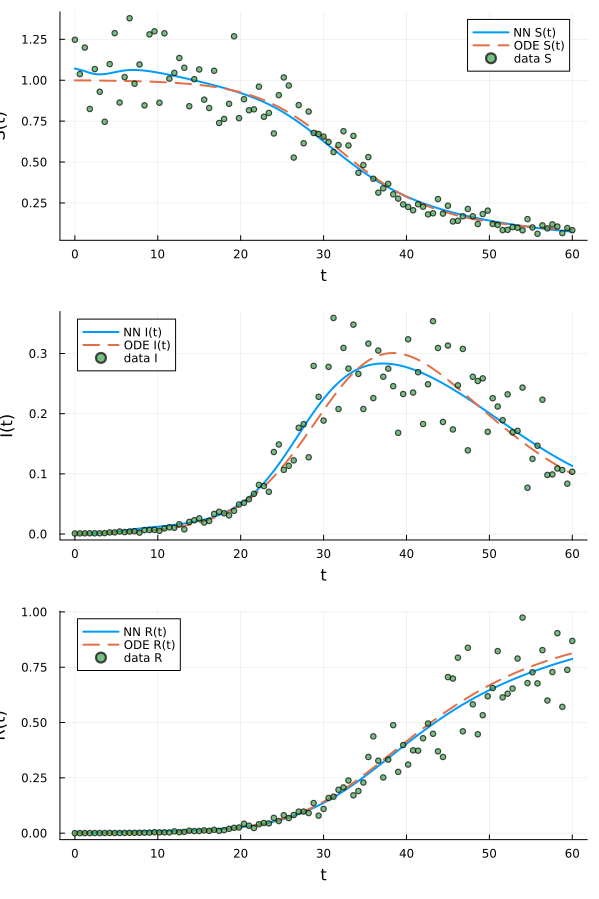

In [7]:
# Build a stateful model bound to the trained params
smodel = Lux.StatefulLuxLayer(NN_model, ps_trained, st)

# A smooth time grid for plotting the NN curve
t_plot = Float32.(collect(range(t_span[1], t_span[2], length=400)))

# NN predictions on the smooth grid (3×N)
ŷ_plot = smodel(permutedims(t_plot))  # 1×N input expected; returns 3×N

# Split true, NN, and noisy series
S_true, I_true, R_true = sol_[1, :], sol_[2, :], sol_[3, :]
S_nn,   I_nn,   R_nn   = vec(ŷ_plot[1, :]), vec(ŷ_plot[2, :]), vec(ŷ_plot[3, :])
S_noisy, I_noisy, R_noisy = Y_train[1, :], Y_train[2, :], Y_train[3, :]

# Panel 1: S(t)
p1 = Plots.plot(t_plot, S_nn; label = "NN S(t)", linewidth = 2)
Plots.plot!(p1, t_obs_array, S_true; label = "ODE S(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p1, t_train, S_noisy; label = "data S", ms = 3, alpha = 0.7)
Plots.xlabel!(p1, "t")
Plots.ylabel!(p1, "S(t)")

# Panel 2: I(t)
p2 = Plots.plot(t_plot, I_nn; label = "NN I(t)", linewidth = 2)
Plots.plot!(p2, t_obs_array, I_true; label = "ODE I(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p2, t_train, I_noisy; label = "data I", ms = 3, alpha = 0.7)
Plots.xlabel!(p2, "t")
Plots.ylabel!(p2, "I(t)")

# Panel 3: R(t)
p3 = Plots.plot(t_plot, R_nn; label = "NN R(t)", linewidth = 2)
Plots.plot!(p3, t_obs_array, R_true; label = "ODE R(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p3, t_train, R_noisy; label = "data R", ms = 3, alpha = 0.7)
Plots.xlabel!(p3, "t")
Plots.ylabel!(p3, "R(t)")

# Combine panels
plt = Plots.plot(p1, p2, p3; layout = (3, 1), size = (600, 900))
display(plt)

#Plots.savefig(plt, "Results/2025-10-13_NNfitWithODELoss.svg")


### Symbolic Regression

In [9]:
t_symbolic = Float32.(collect(range(t_span[1], t_span[2], length=1000))')
ŷ_symbolic = smodel(t_symbolic)

dŷ_symbolicdt = reduce(hcat, [Zygote.jacobian(smodel, [τ])[1] for τ in t_symbolic])

3×1000 Matrix{Float32}:
 -0.00457584   -0.00743285   -0.010958     …  -0.0046398   -0.00461794
 -0.000798795  -0.00055128   -0.000385996     -0.00711316  -0.00708653
 -0.000759656  -0.000496248  -0.000307141      0.0106748    0.0106397

In [ ]:
using SymbolicRegression

Xsr = ŷ_symbolic                                                     # (S,I,R) are features
yS  = dŷ_symbolicdt[1, :]                                           # targets (Vectors)
yI  = dŷ_symbolicdt[2, :]
yR  = dŷ_symbolicdt[3, :]

# Only +, -, * (no division/exp/log), modest size/parsimonious search
opts = SymbolicRegression.Options(
    binary_operators = [+, -, *],
    unary_operators  = [],   # no unary ops
    populations      = 20,
    maxsize          = 18,    # keep small; increase if underfitting
    parsimony        = 1e-4,  # nudge toward simpler formulas
    verbosity        = 1
)

varnames = ["S","I","R"]

function fit_one_rhs(X, y, opts, varnames; iters=400)
    hof = SymbolicRegression.equation_search(
        X, y;
        niterations = iters,
        options     = opts,
        variable_names = varnames,
        parallelism = :serial,
        progress= false
    )
    pareto = SymbolicRegression.calculate_pareto_frontier(hof)
    best   = pareto[end]  # simplest good model is near the end; pick as you like
    expr_str = SymbolicRegression.string_tree(best.tree, opts)
    return (best=best, pareto=pareto, expr_str=expr_str)
end

resS = fit_one_rhs(Xsr, yS, opts, varnames; iters=500)
resI = fit_one_rhs(Xsr, yI, opts, varnames; iters=500)
resR = fit_one_rhs(Xsr, yR, opts, varnames; iters=500)

println("dS/dt ≈ ", resS.expr_str)
println("dI/dt ≈ ", resI.expr_str)
println("dR/dt ≈ ", resR.expr_str)


[ Info: Started!



Expressions evaluated per second: 8.920e+04
Progress: 570 / 10000 total iterations (5.700%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.609e-04  0.000e+00  y = -0.016605
3           1.217e-04  1.395e-01  y = I * -0.10324
5           1.910e-05  9.262e-01  y = (S * I) * -0.29614
7           1.575e-05  9.623e-02  y = ((I * -0.27696) + -0.0031987) * S
13          1.543e-05  3.398e-03  y = (((((R + R) - 1.5898) * -0.12234) - S) * S) * R
15          1.527e-05  5.206e-03  y = ((((R - S) - (1.6097 - R)) * -0.08346) - S) * (R * S)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Exp

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!



Expressions evaluated per second: 8.740e+04
Progress: 546 / 10000 total iterations (5.460%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.727e-05  0.000e+00  y = 0.0018587
3           7.061e-05  1.059e-01  y = S * 0.0063531
5           4.182e-05  2.619e-01  y = (0.34497 - R) * 0.02419
7           3.440e-06  1.249e+00  y = I * ((0.32326 - S) * -0.24949)
9           2.492e-06  1.613e-01  y = ((0.098749 + (I - S)) * I) * -0.25986
13          2.408e-06  8.583e-03  y = (((I * -0.22141) * ((S - 0.34768) * -0.47136)) - -0.00...
                                      028618) * 2.5586
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Pres

[ Info: Final population:
[ Info: Results saved to:


  - outputs\20251013_202337_BERIYw\hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 9.550e+04
Progress: 617 / 10000 total iterations (6.170%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.075e-04  0.000e+00  y = 0.013084
3           1.353e-06  2.188e+00  y = I * 0.096874
5           1.171e-06  7.227e-02  y = (I - 0.0071145) * 0.1002
7           4.732e-07  4.529e-01  y = I * (0.071392 + (I * 0.10806))
9           2.885e-07  2.473e-01  y = (I * ((R * S) + 0.1859)) * 0.33884
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 9.870e+04
Progress: 1240 / 10000 total iterations (12.400%)
════════════

[ Info: Final population:
[ Info: Results saved to:


In [15]:
println("dS/dt ≈ ", resS.expr_str)
println("dI/dt ≈ ", resI.expr_str)
println("dR/dt ≈ ", resR.expr_str)

dS/dt ≈ ((I * S) * (((S + 0.5712638) * -0.06552382) - 0.1911654)) + -0.0028232615
dI/dt ≈ (I + (S * (I + -0.006572002))) * (((S * 0.18286599) + -0.066201866) * 1.0224153)
dR/dt ≈ (((0.3570705 - S) * (((I * -1.041305) + S) * R)) - -0.10323508) * I


In [23]:
using SymbolicRegression, Latexify

varnames = ["S","I","R"]
show_top5 = (pareto, name) -> display(Latexify.latexify(
  ["\\frac{d$name}{dt} = " *
   SymbolicRegression.string_tree(p.tree, opts; variable_names=varnames, pretty=true)
   for p in pareto[1:min(5,end)]];
  env=:align, parse=false))   # <- key fix

show_top5(resS.pareto, "S"); show_top5(resI.pareto, "I"); show_top5(resR.pareto, "R")


L"\begin{align}
\frac{dS}{dt} &= -0.016605 \\
\frac{dS}{dt} &= I * -0.10324 \\
\frac{dS}{dt} &= (S * I) * -0.29614 \\
\frac{dS}{dt} &= ((I * -0.27696) + -0.0031987) * S \\
\frac{dS}{dt} &= (I * ((S * -0.28373) - -0.0115)) + -0.003408
\end{align}
"

L"\begin{align}
\frac{dI}{dt} &= 0.0018593 \\
\frac{dI}{dt} &= S * 0.0063522 \\
\frac{dI}{dt} &= (0.34497 - R) * 0.02419 \\
\frac{dI}{dt} &= I * ((S * 0.27347) + -0.091686) \\
\frac{dI}{dt} &= (0.19855 - ((S + 0.24238) * R)) * I
\end{align}
"

L"\begin{align}
\frac{dR}{dt} &= 0.013084 \\
\frac{dR}{dt} &= I * 0.096874 \\
\frac{dR}{dt} &= (I - 0.0071145) * 0.1002 \\
\frac{dR}{dt} &= I * (0.071392 + (I * 0.10806)) \\
\frac{dR}{dt} &= (((S * R) * 0.31108) + 0.066027) * I
\end{align}
"

In [26]:
true_SIR_par

SIR_params(0.3f0, 0.1f0)